# Numerical solution to the Taylor-Goldstein equation

The eigenvalue problem for internal wave modes with shear is [cf. Grimshaw et al., 2004]

$$
\frac{d}{dz}\lbrace\left[c-U(z)\right]^2\frac{d \phi}{dz} \rbrace + N^2(z)\phi = 0
$$

with boundary conditions $\phi(0) = \phi(-H) = 0$. Many papers omit details for solving this numerically, so here we present a solution using the shooting method for boundary value problems. This method has been applied to similar wave-like eigenvalue problems (e.g., Hazel, 1972; Winters et al...). 

The numerical solution method is as follows: 

- Break up Eq (1) into a system of (two) first-order ODEs by first setting

$$
y_1 = [c-U(z)]^2\phi
$$

$$
y_2 = y_1' \equiv \frac{dy_1}{dz}
$$

 - The two ODEs are
 
$$
\frac{d y_2}{dz}  = -\frac{N(z)^2}{[c-U(z)]^2}y_1
$$

$$
\frac{dy_1}{dz} = y_2
$$

 - Integrate the system by setting $y_1(0) = 0$ (the top boundary condition) and guessing initial values for $y_2(0)$ and $c$. This is the shooting step where we use `odeint` in scipy.
 
 - The goal is to find values of $y_2(0)$ and $c$ so that the boundary condition $y_1(-H)=0$.
 
 - We use an optimization routine `least_squares` in scipy to perform this task. This routine allows one to set bounds on the parameters $y_2(0)$ and $c$ i.e., return physically meaningful results. 
 
 - One thing to note is that the final optimized solution is still dependent on the initial conditions. To ensure that we are searching for the desired mode, we use $c$ from the solution to the shear-free eigenvalue problem as an intitial guess.
 
 
---

## Liu et al equations


$$
    \frac{d^2 \phi}{dz^2}+ \left[\frac{U_{zz}}{U-c} - \frac{N^2}{(U-c)^2} \right]\phi = 0
$$

We basically apply the same approach- Break up Eq (1) into a system of (two) first-order ODEs by first setting

$$
y_1 = \phi
$$

$$
y_2 = y_1' \equiv \frac{dy_1}{dz}
$$

 - The two ODEs are
 
$$
\frac{d y_2}{dz}  = \left[\frac{U_{zz}}{U-c} - \frac{N^2}{(U-c)^2} \right]y_1
$$

$$
\frac{dy_1}{dz} = y_2
$$

In [4]:

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
from scipy.optimize import least_squares, root
from scipy.integrate import solve_bvp, odeint
from scipy.interpolate import interp1d

from iwaves.utils.isw import iwave_modes
from iwaves import IWaveModes
from iwaves.utils.density import double_tanh_rho
#from iwaves.utils.tgsolve import tgsolve

import pdb

%matplotlib inline

In [5]:
# Discretized version of the two ODEs
def odefun(phi, y, c, Fn, Fu):

    phi1, phi2 = phi
    dphi1 = phi2*1
    uc2 = (c - Fu(y))**2
    #uc2 = (Fu(y)-c)**2

    dphi2 = -Fn(y)/uc2 * phi1

    return [dphi1, dphi2]

In [6]:
# Discretized version of the two ODEs
def odefun2(phi, y, c, Fn, Fu, Fuzz):

    phi1, phi2 = phi
    dphi1 = phi2*1
    uc = c - Fu(y)

    dphi2 = (Fuzz(y)/uc - Fn(y)/uc**2) * phi1

    return [dphi1, dphi2]

In [7]:
# This is the objective function we are trying to optimize i.e. return y_1(-H) = 0 
def objective(args, Fn, Fu, z):
    phi_1 = 0. # Bottom BC (hard-wired for now...)
    u2_0, cn = args
    
    U = odeint(odefun, [phi_1, u2_0], z, args=(cn, Fn, Fu))
    u1 = U[:,0]
    u2 = U[:,1]
    # Ensure the top bc is zero
    return u1[0], u1[-1]

In [8]:
# This is the objective function we are trying to optimize i.e. return y_1(-H) = 0 
def objective2(args, Fn, Fu, Fuzz, z):
    phi_1 = 0. # Bottom BC (hard-wired for now...)
    u2_0, cn = args
    
    U = odeint(odefun2, [phi_1, u2_0], z, args=(cn, Fn, Fu, Fuzz))
    u1 = U[:,0]
    u2 = U[:,1]
    # Ensure the top bc is zero
    return u1[0], u1[-1]

In [9]:
def tgsolve(z, U, N2, mode):
    """
    Taylor-Goldstein equation solver
    """

    dz = np.abs(z[1]-z[0]) # Assume constant spacing

    # Guess the initial conditions from the shear-free solution
    phin, cn = iwave_modes(N2, dz)
    cguess = cn[mode]
    phi_2_guess = 0.15

    # Functions mapping the velocity and N^2 profile to any height
    # (Use interpolation here although we could ascribe an analytic expression)
    Fn = interp1d(z, N2, kind=2, fill_value='extrapolate')
    Fu = interp1d(z, U, kind=2, fill_value='extrapolate')
    
    # Optimization step
    #soln = least_squares(objective, [phi_2_guess, cguess], xtol=1e-8, \
    #        bounds=((0,cguess-cguess*0.55), (2., cguess+cguess*0.55)),\
    #        args=(Fn,Fu, z), 
    #        verbose=0,
    #        diff_step=1e-4,
    #        method='dogbox',
    #    )
    soln = root(objective, [phi_2_guess, cguess], args=(Fn,Fu, z), method='krylov', tol=1e-8)

    # Go back and get the optimal profile using the solution
    phi_2, cn = soln['x']
    phiall = odeint(odefun, [0, phi_2], z, args=(cn,Fn,Fu))
    phi = phiall[:,0]

    # Normalize the profile
    idx = np.where(np.abs(phi)==np.abs(phi).max())[0][0]
    phi /= phi[idx]
       
    #print phi[0], phi[-1]
    if np.abs(phi[-1]) > 1e-6:
        print 'Warning: Convergence Issue with TG-solver'
    
    return phi, cn



In [10]:
def tgsolvefull(z, U, N2, mode):
    """
    Taylor-Goldstein equation solver
    """

    dz = np.abs(z[1]-z[0]) # Assume constant spacing

    # Guess the initial conditions from the shear-free solution
    phin, cn = iwave_modes(N2, dz)
    cguess = cn[mode]
    phi_2_guess = 0.15
    
    # Compute the second derivative
    Uz = np.gradient(U, -dz) 
    Uzz = np.gradient(Uz, -dz) 


    # Functions mapping the velocity and N^2 profile to any height
    # (Use interpolation here although we could ascribe an analytic expression)
    Fn = interp1d(z, N2, kind=2, fill_value='extrapolate')
    Fu = interp1d(z, U, kind=2, fill_value='extrapolate')
    Fuzz = interp1d(z, Uzz, kind=2, fill_value='extrapolate')

    # Optimization step
    #soln = least_squares(objective, [phi_2_guess, cguess], xtol=1e-8, \
    #        bounds=((0,cguess-cguess*0.55), (2., cguess+cguess*0.55)),\
    #        args=(Fn,Fu, z), 
    #        verbose=0,
    #        diff_step=1e-4,
    #        method='dogbox',
    #    )
    soln = root(objective2, [phi_2_guess, cguess], args=(Fn,Fu,Fuzz, z), method='krylov', tol=1e-8)

    # Go back and get the optimal profile using the solution
    phi_2, cn = soln['x']
    phiall = odeint(odefun2, [0, phi_2], z, args=(cn,Fn,Fu,Fuzz))
    phi = phiall[:,0]

    # Normalize the profile
    idx = np.where(np.abs(phi)==np.abs(phi).max())[0][0]
    phi /= phi[idx]
       
    #print phi[0], phi[-1]
    if np.abs(phi[-1]) > 1e-6:
        print 'Warning: Convergence Issue with TG-solver'
    
    return phi, cn


In [11]:
def calc_alpha_wshear(phi, c, U, dz):
    """
    alpha with shear (see Grimshaw 2004)
    """
    phi_z = np.gradient(phi, -np.abs(dz))
    #num = 3*np.trapz((c-U)**2. * phi_z**3., dx = np.abs(dz))
    #den = 2*np.trapz((c-U) * phi_z**2., dx = np.abs(dz))
    
    # Liu et al definition
    Uz = np.gradient(U, -np.abs(dz))

    num = 3*c*np.trapz( 1/(c-U) * (phi_z - Uz/(U-c)*phi)**3., dx = np.abs(dz))
    den = 2*np.trapz( 1/(c-U) * (phi_z - Uz/(U-c)*phi)**2., dx = np.abs(dz))

    return num/den

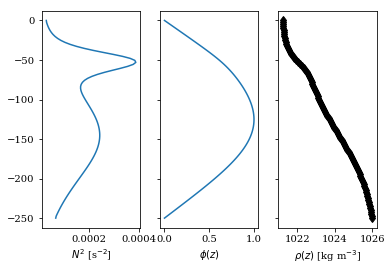

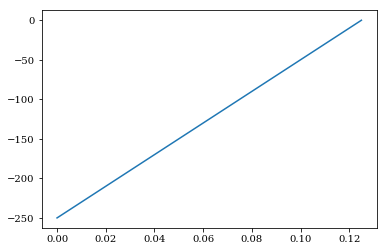

In [12]:
# KISSME-like conditions

# Create some initial data
d = 250
Nz = 100
N = 0.01
S = 0.0005

RHO0 = 1024.
GRAV = 9.81

mode = 0
# Create the density initial conditions
z = np.linspace(0, d, Nz)
dz = np.abs(z[1]-z[0]) # Assume constant spacing

rho = double_tanh_rho(-z, 1021.11, 1.01, 4.17, 51.75, 145.27, 15.8, 82.35)
#rho = double_tanh_rho(-z, 1021.11, 0.01, 4.17, 51.75, 145.27, 15.8, 82.35)


iw = IWaveModes(rho[::-1], -z[::-1])
iw(-d, dz, mode)
iw.plot_modes()

# Linear shear (no Uzz)
U = S*iw.Z - S*iw.Z[-1]

# Exponential decay
#U = 0.2*np.exp(iw.Z/100.)

N2 = iw.N2

plt.figure()
plt.plot(U, iw.Z)

r10, r01, r20, he = iw.calc_nonlin_params()


In [13]:
z = iw.Z

phis, cns = tgsolvefull(z,U,N2,mode)
phi, cn = tgsolve(z,U,N2,mode)

alpha_s = calc_alpha_wshear(phis, cns, U, dz)
alpha = calc_alpha_wshear(phi, cn, U, dz)
print iw.Z[0], iw.Z[-1]

print cn, cns, alpha, -r10*2*iw.c1, alpha_s


plt.figure(figsize=(6,12))
#plt.subplot(141)
plt.plot(phis,z)
plt.plot(phi,z,'k--')
plt.plot(0*phi, z,':',c='0.5')
plt.plot(iw.phi, iw.Z,'r')
plt.plot([0,1],[-d/2,-d/2],':',c='0.5')

plt.figure(figsize=(12,6))
plt.subplot(141)
plt.plot(phis,z)
plt.plot(phi,z,'k--')
plt.plot(0*phi, z,':',c='0.5')
plt.plot(iw.phi, iw.Z)
plt.plot([0,1],[-d/2,-d/2],':',c='0.5')


plt.subplot(142)
plt.plot(N2,z)

plt.subplot(143)
plt.plot( 1/(cns-U),z)

plt.subplot(144)
dphis = np.gradient(phis,-dz)
plt.plot(phi - phis, z)

plt.show()

ValueError: Jacobian inversion yielded zero vector. This indicates a bug in the Jacobian approximation.

In [386]:
# Check the solution
dphi = np.gradient(phis,-dz)
dff = (cns-U)**2 * dphi

dphi2 = np.gradient(dff,-dz)

np.linalg.norm(dphi2 * N2*phis)

U, z



(array([ 0.25      ,  0.24747475,  0.24494949,  0.24242424,  0.23989899,
         0.23737374,  0.23484848,  0.23232323,  0.22979798,  0.22727273,
         0.22474747,  0.22222222,  0.21969697,  0.21717172,  0.21464646,
         0.21212121,  0.20959596,  0.20707071,  0.20454545,  0.2020202 ,
         0.19949495,  0.1969697 ,  0.19444444,  0.19191919,  0.18939394,
         0.18686869,  0.18434343,  0.18181818,  0.17929293,  0.17676768,
         0.17424242,  0.17171717,  0.16919192,  0.16666667,  0.16414141,
         0.16161616,  0.15909091,  0.15656566,  0.1540404 ,  0.15151515,
         0.1489899 ,  0.14646465,  0.14393939,  0.14141414,  0.13888889,
         0.13636364,  0.13383838,  0.13131313,  0.12878788,  0.12626263,
         0.12373737,  0.12121212,  0.11868687,  0.11616162,  0.11363636,
         0.11111111,  0.10858586,  0.10606061,  0.10353535,  0.1010101 ,
         0.09848485,  0.0959596 ,  0.09343434,  0.09090909,  0.08838384,
         0.08585859,  0.08333333,  0.08080808,  0.0

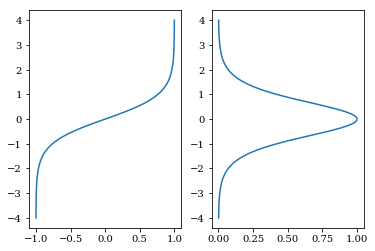

In [348]:
# Hazel, 1972 - Mixing layer model

Nz = 100
z = np.linspace(-4,4, Nz)

U = np.tanh(z)

N2 = 1/np.cosh(z)**2 # sech^2(z)

mode=0

plt.figure()
plt.subplot(121)
plt.plot(U,z)
plt.subplot(122)
plt.plot(N2,z)
plt.show()

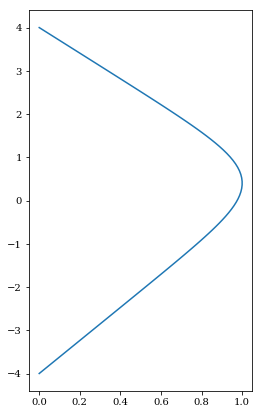

In [281]:
phi, cn = tgsolve(z,U,N2,mode)

plt.figure(figsize=(4,7))
plt.plot(phi,z)
plt.show()


In [213]:
phin, cn = iwave_modes(N2, dz)
cn[0]

54.674614432443157